In [24]:
import pandas as pd
df = pd.read_csv('tw_train.csv')
df


,交易日,交易別,股票代號,股票名稱,股數,單價,進帳/出帳,Unnamed: 7,XIRR,總成本(賣-買),總價值(現值+配息),總獲利(%),總配息
0,2021/01/11,買,0050,NaN,130.0,131.90,-17147,NaN,23.39%,-448141.0,719607.0,60.576024,28842.0
1,2021/01/15,買,2330,台積,20.0,612.00,-12240,NaN,NaN,NaN,NaN,NaN,NaN
2,2021/01/20,買,2376,技嘉,40.0,79.50,-3180,NaN,NaN,NaN,NaN,NaN,NaN
3,2021/01/25,買,2330,台積,5.0,644.00,-3220,NaN,NaN,NaN,NaN,NaN,NaN
4,2021/01/29,買,2330,NaN,5.0,603.00,-3015,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,2024/11/29,買,00631L,NaN,10.0,222.75,-2227,NaN,NaN,NaN,NaN,NaN,NaN
140,2025/01/13,買,006208,NaN,30.0,114.70,-3445,NaN,NaN,NaN,NaN,NaN,NaN
141,2025/01/15,買,006208,NaN,20.0,113.25,-2268,NaN,NaN,NaN,NaN,NaN,NaN
142,2025/01/15,買,00631L,NaN,10.0,232.55,-2328,NaN,NaN,NaN,NaN,NaN,NaN


處理股票: 0050
處理股票: 0056
處理股票: 006208
處理股票: 00631L
處理股票: 00646
處理股票: 2330
處理股票: 2376
處理股票: 2884


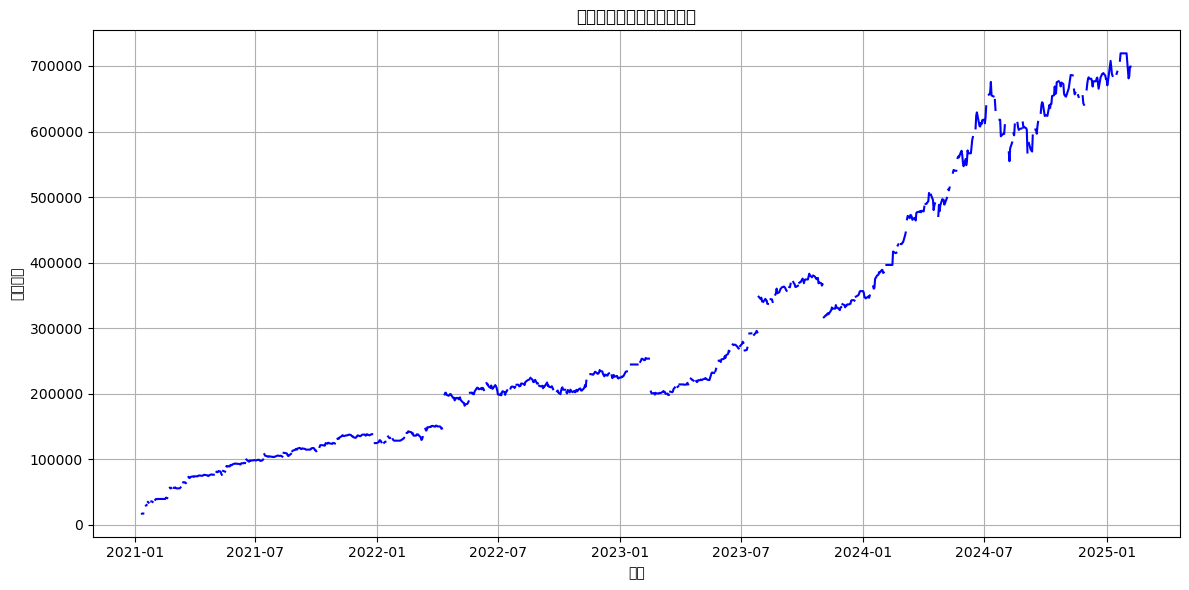

C:\Users\Tim\AppData\Local\Temp\ipykernel_13408\29627942.py:82: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  daily_returns = portfolio_value.pct_change().dropna()


每日報酬率樣本：
2021-01-13    0.024224
2021-01-14   -0.009239
2021-01-15    0.000000
2021-01-18    0.699251
2021-01-19    0.029093
Freq: B, dtype: float64
年化夏普值 (Annualized Sharpe Ratio): 1.88
最大回撤 (Maximum Drawdown): 22.21%
XIRR: 22.72%


In [18]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import newton
from datetime import datetime

# =============================
# 1. 準備交易記錄資料
# -----------------------------
# 假設您的 CSV 資料包含至少 '股票代號'、'交易日'、'股數' 與 '進帳/出帳'
df = pd.read_csv('tw_train.csv')

# 將「交易日」轉換為 datetime 格式（假設格式為 'YYYY/MM/DD' 或其他格式）
df['交易日'] = pd.to_datetime(df['交易日'])
df = df.sort_values('交易日')

# =============================
# 2. 計算每日各股票累積持有股數
# -----------------------------
# 依據「交易日」與「股票代號」彙整當日買賣股數
pivot = df.pivot_table(index='交易日', columns='股票代號', values='股數', aggfunc='sum')

# 建立完整日期範圍（以商業日為單位）
date_range = pd.date_range(start=df['交易日'].min(), end=pd.Timestamp.today(), freq='B')
# 補齊 pivot DataFrame，當天無交易則以 0 表示
pivot = pivot.reindex(date_range, fill_value=0)
# 計算累積持有股數（每日累積加總）
cum_holdings = pivot.cumsum()

# =============================
# 3. 定義函式抓取每日收盤價（僅使用前向填補）
# -----------------------------
def get_daily_price(stock_code, start_date, end_date):
    """
    使用 yfinance 抓取指定股票從 start_date 到 end_date 的每日收盤價。
    台灣股票的 ticker 格式通常為 "股票代號.TW"
    """
    ticker = f"{stock_code}.TW"
    data = yf.download(ticker, start=start_date, end=end_date, progress=False)
    if data.empty:
        raise ValueError(f"無法取得 {ticker} 的資料")
    return data['Close']

# =============================
# 4. 計算每日組合市值
# -----------------------------
# 初始化一個 Series 用來儲存每日組合市值
portfolio_value = pd.Series(0, index=date_range)

# 逐一對各股票計算每日市值：當日持股數 * 當日收盤價
for stock in cum_holdings.columns:
    print(f"處理股票: {stock}")
    try:
        start_str = date_range[0].strftime('%Y-%m-%d')
        end_str = date_range[-1].strftime('%Y-%m-%d')
        price_series = get_daily_price(stock, start_str, end_str)
        # 依據完整日期範圍重新索引，僅用前向填補缺失值
        price_series = price_series.reindex(date_range).ffill()
        stock_value = cum_holdings[stock] * price_series
        portfolio_value += stock_value
    except Exception as e:
        print(f"取得股票 {stock} 價格資料時發生錯誤: {e}")

# 補齊組合市值序列（先用前向填補，再用後向填補以確保首尾無缺失）
# portfolio_value = portfolio_value.fillna(method='ffill').fillna(method='bfill')

# 繪製組合市值走勢圖
plt.figure(figsize=(12, 6))
plt.plot(portfolio_value.index, portfolio_value.values, linestyle='-', color='blue')
plt.xlabel('日期')
plt.ylabel('組合市值')
plt.title('每日股票組合總市值走勢圖')
plt.grid(True)
plt.tight_layout()
plt.show()

# =============================
# 5. 計算績效指標：年化夏普值、最大回撤
# -----------------------------
# 5.1 每日報酬率（百分比變化）
daily_returns = portfolio_value.pct_change().dropna()
print("每日報酬率樣本：")
print(daily_returns.head())

# 5.2 設定無風險利率（年化），例如 1% 即 0.01，您可根據實際情況修改
risk_free_rate = 0.01  # 年化無風險利率
daily_risk_free_rate = risk_free_rate / 252

# 5.3 年化夏普值計算：考慮無風險利率
if daily_returns.empty:
    print("無足夠每日報酬率資料，無法計算夏普值。")
    annual_sharpe = np.nan
else:
    mean_daily_return = daily_returns.mean()
    std_daily_return = daily_returns.std()
    if std_daily_return == 0:
        print("每日報酬率標準差為 0，無法計算夏普值。")
        annual_sharpe = np.nan
    else:
        # (mean_daily_return - daily_risk_free_rate) 是扣除每日無風險利率後的超額報酬
        annual_sharpe = ((mean_daily_return - daily_risk_free_rate) / std_daily_return) * np.sqrt(252)
print("年化夏普值 (Annualized Sharpe Ratio): {:.2f}".format(annual_sharpe))

# 5.4 最大回撤計算
running_max = portfolio_value.cummax()
drawdown = (portfolio_value - running_max) / running_max
max_drawdown = drawdown.min()  # 此值為負值，代表最大跌幅
print("最大回撤 (Maximum Drawdown): {:.2%}".format(abs(max_drawdown)))

# =============================
# 6. 計算 XIRR (內部報酬率)
# -----------------------------
# 6.1 建立現金流序列：將每筆交易的「進帳/出帳」視為現金流 (日期, 金額)
cashflows = list(df[['交易日', '進帳/出帳']].itertuples(index=False, name=None))

# 6.2 定義函式，利用 yfinance 取得最新價格
def get_current_price_yf(stock_code):
    """
    使用 yfinance 取得指定股票的即時價格，
    若無即時價格，則取得最近一個交易日的收盤價；
    如果抓到的價格為 0，則印出錯誤訊息並回傳 None。
    """
    ticker = f"{stock_code}.TW"
    try:
        t = yf.Ticker(ticker)
        info = t.info
        price = info.get('regularMarketPrice', None)
        if price is None:
            data = yf.download(ticker, period="1d", progress=False)
            if data.empty:
                print(f"警告: {ticker} 無法取得任何價格資料。")
                return None
            price = data['Close'].iloc[-1]
        if price == 0:
            print(f"錯誤: {ticker} 抓到的價格為 0，請檢查資料來源！")
            return None
        return price
    except Exception as e:
        print(f"取得 {ticker} 即時價格失敗，錯誤：{e}")
        return None

# 6.3 根據所有股票淨持股計算目前投資組合現值
net_holdings = df.groupby('股票代號')['股數'].sum()
portfolio_snapshot = 0
for stock, shares in net_holdings.items():
    if shares != 0:
        price = get_current_price_yf(stock)
        if price is not None:
            portfolio_snapshot += shares * price

# 使用今日（normalize 到 00:00）作為現金流日期
today = pd.Timestamp.today().normalize()
cashflows.append((today, portfolio_snapshot))

# 6.4 定義 XNPV 與 XIRR 函式
def xnpv(rate, cashflows):
    """
    計算不規則現金流的淨現值 (NPV)
    :param rate: 折現率（例如 0.1 代表 10%）
    :param cashflows: [(date, amount), ...]，其中 date 為 pd.Timestamp
    :return: NPV
    """
    t0 = min(date for date, _ in cashflows)
    return sum(cf / ((1 + rate) ** ((date - t0).days / 365.0))
               for date, cf in cashflows)

def xirr(cashflows, guess=0.1):
    """
    利用牛頓法計算 XIRR，使 xnpv(rate, cashflows) = 0
    :param cashflows: [(date, amount), ...]
    :param guess: 初始猜測值（預設 0.1，即 10%）
    :return: XIRR（折現率）
    """
    return newton(lambda r: xnpv(r, cashflows), guess)

irr = xirr(cashflows)
print("XIRR: {:.2%}".format(irr))


處理股票: 0050
處理股票: 0056
處理股票: 006208
處理股票: 00631L
處理股票: 00646
處理股票: 2330
處理股票: 2376
處理股票: 2884


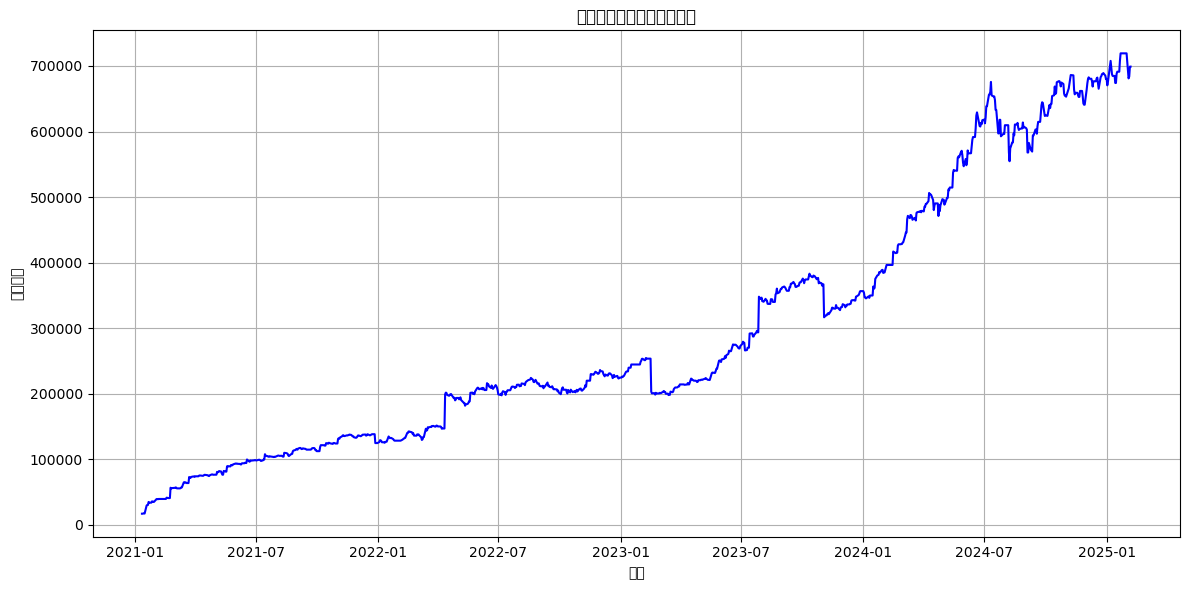

TWR 每日報酬率樣本：
2021-01-12    0.000000
2021-01-13    0.024224
2021-01-14   -0.009239
2021-01-15    0.702379
2021-01-18    0.699251
dtype: float64
年化 TWR 夏普值 (Annualized Sharpe Ratio based on TWR): 2.50
最大回撤 (Maximum Drawdown): 22.21%
XIRR: 22.72%


In [23]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import newton
from datetime import datetime

import warnings
warnings.filterwarnings("ignore", message="Glyph.*missing from current font")
warnings.filterwarnings("ignore", message="Glyph.*missing from current font")

# =============================
# 1. 準備交易記錄資料
# -----------------------------
# 讀取包含至少 '股票代號'、'交易日'、'股數' 與 '進帳/出帳' 的 CSV 資料
df = pd.read_csv('tw_train.csv')

# 轉換「交易日」為 datetime 格式（請依實際格式修改）
df['交易日'] = pd.to_datetime(df['交易日'])
df = df.sort_values('交易日')

# =============================
# 2. 計算每日各股票累積持有股數
# -----------------------------
# 依據「交易日」與「股票代號」彙整當日買賣股數
pivot = df.pivot_table(index='交易日', columns='股票代號', values='股數', aggfunc='sum')

# 建立完整日期範圍（以商業日為單位）
date_range = pd.date_range(start=df['交易日'].min(), end=pd.Timestamp.today(), freq='B')
# 補齊 pivot DataFrame，當天無交易則以 0 表示
pivot = pivot.reindex(date_range, fill_value=0)

# 計算累積持有股數（每日累積加總）
cum_holdings = pivot.cumsum()

# =============================
# 3. 定義函式抓取每日收盤價（僅使用前向填補）
# -----------------------------
def get_daily_price(stock_code, start_date, end_date):
    """
    使用 yfinance 抓取指定股票從 start_date 到 end_date 的每日收盤價。
    對於台灣股票，ticker 格式通常為 "股票代號.TW"
    """
    ticker = f"{stock_code}.TW"
    data = yf.download(ticker, start=start_date, end=end_date, progress=False)
    if data.empty:
        raise ValueError(f"無法取得 {ticker} 的資料")
    return data['Close']

# =============================
# 4. 計算每日組合市值
# -----------------------------
# 初始化一個 Series 用來儲存每日組合市值，索引為完整日期範圍
portfolio_value = pd.Series(0, index=date_range)

# 逐一對各股票計算每日市值：當日累積持股數 * 當日收盤價
for stock in cum_holdings.columns:
    print(f"處理股票: {stock}")
    try:
        start_str = date_range[0].strftime('%Y-%m-%d')
        end_str = date_range[-1].strftime('%Y-%m-%d')
        price_series = get_daily_price(stock, start_str, end_str)
        # 根據完整日期範圍重新索引，僅用前向填補缺失值
        price_series = price_series.reindex(date_range).ffill()
        stock_value = cum_holdings[stock] * price_series
        portfolio_value += stock_value
    except Exception as e:
        print(f"取得股票 {stock} 價格資料時發生錯誤: {e}")

# 補齊組合市值序列（先用前向填補，再用後向填補以確保首尾無缺失）
portfolio_value = portfolio_value.ffill().bfill()

# 繪製組合市值走勢圖
plt.figure(figsize=(12, 6))
plt.plot(portfolio_value.index, portfolio_value.values, linestyle='-', color='blue')
plt.xlabel('日期')
plt.ylabel('組合市值')
plt.title('每日股票組合總市值走勢圖')
plt.grid(True)
plt.tight_layout()
plt.show()

# =============================
# 5. 計算績效指標：TWR 夏普值與最大回撤
# -----------------------------
# 5.1 取得每日現金流：以 CSV 中「進帳/出帳」進行加總
# 這代表當天因外部現金流入（正值）或流出（負值）的金額
cf_series = df.groupby('交易日')['進帳/出帳'].sum()
cf_series = cf_series.reindex(date_range, fill_value=0)

# 5.2 計算每日 TWR 回報
# 公式：若 t 為某天，則
#   R_t = (V_t - CF_t) / V_{t-1} - 1
# 注意：若前一日市值為 0，則無法計算，該天將被跳過
twr_returns = []
twr_dates = []
for i in range(1, len(portfolio_value)):
    V_prev = portfolio_value.iloc[i-1]
    V_today = portfolio_value.iloc[i]
    CF_today = cf_series.iloc[i]  # 當天的外部現金流
    # 若前一天市值為 0，跳過（或可考慮其他處理方式）
    if V_prev == 0:
        continue
    # TWR 回報排除了當天現金流的影響
    r = (V_today - CF_today) / V_prev - 1
    twr_returns.append(r)
    twr_dates.append(portfolio_value.index[i])

# 建立 TWR 日報酬率 Series
twr_returns_series = pd.Series(twr_returns, index=twr_dates)
print("TWR 每日報酬率樣本：")
print(twr_returns_series.head())

# 5.3 設定無風險利率（年化），例如 1%（0.01），根據需求可調整
risk_free_rate = 0.02  # 年化無風險利率
daily_risk_free_rate = risk_free_rate / 252

# 5.4 計算 TWR 基礎下的年化夏普值
if twr_returns_series.empty:
    print("無足夠 TWR 每日報酬率資料，無法計算夏普值。")
    annual_sharpe = np.nan
else:
    mean_daily_return = twr_returns_series.mean()
    std_daily_return = twr_returns_series.std()
    if std_daily_return == 0:
        print("TWR 每日報酬率標準差為 0，無法計算夏普值。")
        annual_sharpe = np.nan
    else:
        # 扣除每日無風險利率後的超額報酬，再年化
        annual_sharpe = ((mean_daily_return - daily_risk_free_rate) / std_daily_return) * np.sqrt(252)
print("年化 TWR 夏普值 (Annualized Sharpe Ratio based on TWR): {:.2f}".format(annual_sharpe))

# 5.5 最大回撤計算（使用原始組合市值序列）
running_max = portfolio_value.cummax()
drawdown = (portfolio_value - running_max) / running_max
max_drawdown = drawdown.min()  # 為負值，代表最大跌幅
print("最大回撤 (Maximum Drawdown): {:.2%}".format(abs(max_drawdown)))

# =============================
# 6. 計算 XIRR (內部報酬率)
# -----------------------------
# 6.1 建立現金流序列：將每筆交易的「進帳/出帳」視為現金流 (日期, 金額)
cashflows = list(df[['交易日', '進帳/出帳']].itertuples(index=False, name=None))

# 6.2 定義函式，利用 yfinance 取得最新價格
def get_current_price_yf(stock_code):
    """
    使用 yfinance 取得指定股票的即時價格，
    若無即時價格，則取得最近一個交易日的收盤價；
    如果抓到的價格為 0，則印出錯誤訊息並回傳 None。
    """
    ticker = f"{stock_code}.TW"
    try:
        t = yf.Ticker(ticker)
        info = t.info
        price = info.get('regularMarketPrice', None)
        if price is None:
            data = yf.download(ticker, period="1d", progress=False)
            if data.empty:
                print(f"警告: {ticker} 無法取得任何價格資料。")
                return None
            price = data['Close'].iloc[-1]
        if price == 0:
            print(f"錯誤: {ticker} 抓到的價格為 0，請檢查資料來源！")
            return None
        return price
    except Exception as e:
        print(f"取得 {ticker} 即時價格失敗，錯誤：{e}")
        return None

# 6.3 根據所有股票淨持股計算目前投資組合現值
net_holdings = df.groupby('股票代號')['股數'].sum()
portfolio_snapshot = 0
for stock, shares in net_holdings.items():
    if shares != 0:
        price = get_current_price_yf(stock)
        if price is not None:
            portfolio_snapshot += shares * price

# 6.4 將最新組合市值作為最後一筆現金流，日期取今日（normalize 到 00:00）
today = pd.Timestamp.today().normalize()
cashflows.append((today, portfolio_snapshot))

# 6.5 定義 XNPV 與 XIRR 函式
def xnpv(rate, cashflows):
    """
    計算不規則現金流的淨現值 (NPV)
    :param rate: 折現率（例如 0.1 代表 10%）
    :param cashflows: [(date, amount), ...]，其中 date 為 pd.Timestamp
    :return: NPV
    """
    t0 = min(date for date, _ in cashflows)
    return sum(cf / ((1 + rate) ** ((date - t0).days / 365.0))
               for date, cf in cashflows)

def xirr(cashflows, guess=0.1):
    """
    利用牛頓法計算 XIRR，使 xnpv(rate, cashflows) = 0
    :param cashflows: [(date, amount), ...]
    :param guess: 初始猜測值（預設 0.1，即 10%）
    :return: XIRR（折現率）
    """
    return newton(lambda r: xnpv(r, cashflows), guess)

irr = xirr(cashflows)
print("XIRR: {:.2%}".format(irr))



In [57]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime

# =============================
# 1. 讀取並處理交易記錄資料
# -----------------------------
df = pd.read_csv('tw_train.csv')
df['交易日'] = pd.to_datetime(df['交易日'])
df = df.sort_values('交易日')

# 修正股數方向：賣出股數為負
def fix_share_sign(row):
    if (row['交易別'] == '賣') and (row['股數'] > 0):
        row['股數'] = -row['股數']
    return row

df = df.apply(fix_share_sign, axis=1)

# =============================
# 2. 建立每日累積持股數 (cum_holdings)
# -----------------------------
pivot = df.pivot_table(index='交易日', columns='股票代號', values='股數', aggfunc='sum')
start_date = df['交易日'].min()
end_date = pd.Timestamp.today()
date_range = pd.date_range(start=start_date, end=end_date, freq='B')

pivot = pivot.reindex(date_range, fill_value=0)
pivot = pivot.fillna(0)
cum_holdings = pivot.cumsum()

# =============================
# 3. 取得股票價格 & 計算每日組合市值
# -----------------------------
def get_daily_price(stock_code, start_date, end_date):
    ticker = f"{stock_code}.TW"
    data = yf.download(ticker, start=start_date, end=end_date, progress=False)
    if data.empty:
        raise ValueError(f"無法取得 {ticker} 的資料")
    return data['Close']

portfolio_value = pd.Series(0, index=date_range)

for stock in cum_holdings.columns:
    print(f"處理股票: {stock}")
    try:
        start_str = date_range[0].strftime('%Y-%m-%d')
        end_str = date_range[-1].strftime('%Y-%m-%d')
        price_series = get_daily_price(stock, start_str, end_str)
        price_series = price_series.reindex(date_range).ffill()
        stock_value = cum_holdings[stock] * price_series
        portfolio_value += stock_value
    except Exception as e:
        print(f"取得股票 {stock} 價格資料失敗: {e}")

portfolio_value = portfolio_value.ffill().bfill()

# =============================
# 4. 計算「已實現現金」、「總成本」、「總獲利」
# -----------------------------

# (a) 累積入金 (總成本)：取所有「進帳/出帳 < 0」的交易，轉為正值後加總
total_investment = -df[df['進帳/出帳'] < 0]['進帳/出帳'].sum()

# (b) 已實現現金：取所有「進帳/出帳 > 0」的交易，直接加總
realized_cash = df[df['進帳/出帳'] > 0]['進帳/出帳'].sum()

# (c) 最終組合市值 (最後一天)
final_portfolio_value = portfolio_value.iloc[-1]

# (d) 總資產 = 組合市值 + 已實現現金
total_assets = final_portfolio_value + realized_cash

# (e) 總獲利 = 總資產 - 總成本
total_profit = total_assets - total_investment

# (f) 總獲利百分比
total_profit_pct = (total_profit / total_investment) * 100

# =============================
# 5. 印出「總成本」與「總獲利」
# -----------------------------
print("\n=== 總結報告 ===")
print(f"總成本（累積入金）：{total_investment:,.2f} 元")
print(f"已實現現金（賣出所得）：{realized_cash:,.2f} 元")
print(f"最終組合市值（現有持股）：{final_portfolio_value:,.2f} 元")
print(f"總資產（已實現現金 + 組合市值）：{total_assets:,.2f} 元")
print(f"總獲利：{total_profit:,.2f} 元")
print(f"總獲利百分比：{total_profit_pct:.2f}%")


處理股票: 0050
處理股票: 0056
處理股票: 006208
處理股票: 00631L
處理股票: 00646
處理股票: 2330
處理股票: 2376
處理股票: 2884

=== 總結報告 ===
總成本（累積入金）：661,551.00 元
已實現現金（賣出所得）：241,149.00 元
最終組合市值（現有持股）：688,123.09 元
總資產（已實現現金 + 組合市值）：929,272.09 元
總獲利：267,721.09 元
總獲利百分比：40.47%


處理股票: 0050
處理股票: 0056
處理股票: 006208
處理股票: 00631L
處理股票: 00646
處理股票: 2330
處理股票: 2376
處理股票: 2884


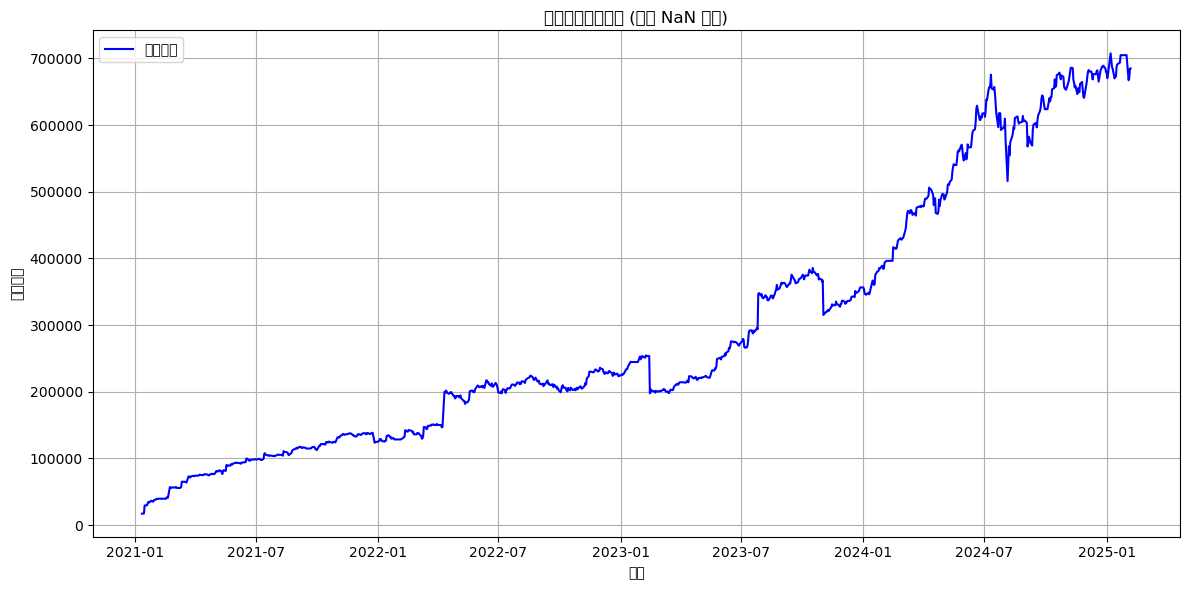

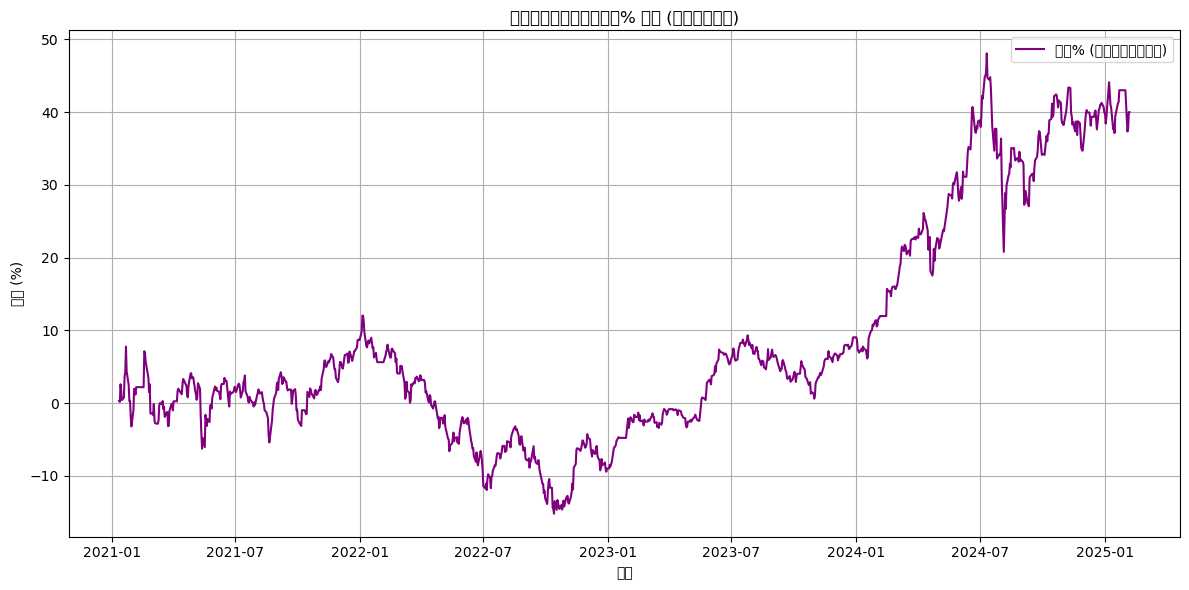

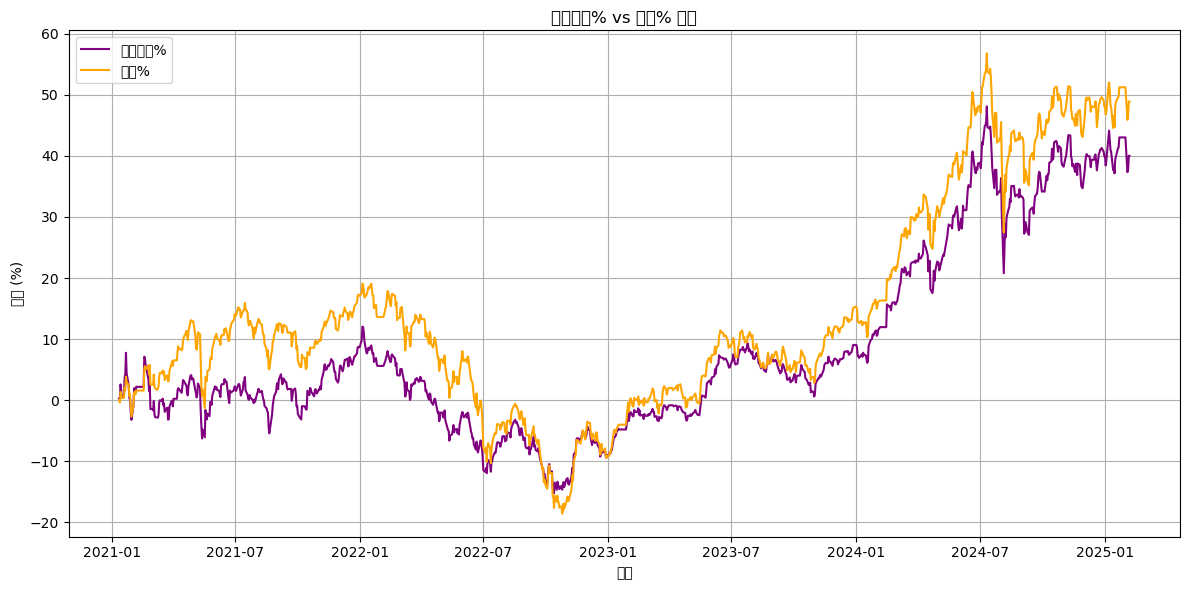

In [21]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import newton

# =============================
# 1. 讀取並處理交易記錄資料
# -----------------------------
# 假設 CSV 檔案包含：'交易日','交易別','股票代號','股數','進帳/出帳'
df = pd.read_csv('tw_train.csv')

# (a) 將「交易日」轉換為 datetime 格式（依您的格式，例如 '%Y/%m/%d'）
df['交易日'] = pd.to_datetime(df['交易日'])
# (b) 日期排序
df = df.sort_values('交易日')

# (c) 修正股數方向：如果「交易別」= '賣'，則股數轉為負值
def fix_share_sign(row):
    if (row['交易別'] == '賣') and (row['股數'] > 0):
        row['股數'] = -row['股數']
    return row

df = df.apply(fix_share_sign, axis=1)

# =============================
# 2. 建立每日累積持股數 (cum_holdings)
# -----------------------------
# 2.1 pivot_table：index='交易日', columns='股票代號', values='股數'
pivot = df.pivot_table(
    index='交易日',
    columns='股票代號',
    values='股數',
    aggfunc='sum'
)

# 2.2 建立以商業日(B)為頻率的日期範圍，從最早交易日到今天
start_date = df['交易日'].min()
end_date = pd.Timestamp.today()
date_range = pd.date_range(start=start_date, end=end_date, freq='B')

# 2.3 reindex：補齊無交易日，填 0
pivot = pivot.reindex(date_range, fill_value=0)
# 若仍有 NaN，統一補 0
pivot = pivot.fillna(0)

# 2.4 計算每日累積持股數
cum_holdings = pivot.cumsum()

# =============================
# 3. 定義函式：利用 yfinance 取得每日收盤價
# -----------------------------
def get_daily_price(stock_code, start_date, end_date):
    ticker = f"{stock_code}.TW"
    data = yf.download(ticker, start=start_date, end=end_date, progress=False)
    if data.empty:
        raise ValueError(f"無法取得 {ticker} 的資料")
    return data['Close']

# =============================
# 4. 計算每日組合市值 (portfolio_value)
# -----------------------------
portfolio_value = pd.Series(0, index=date_range)

for stock in cum_holdings.columns:
    print(f"處理股票: {stock}")
    try:
        start_str = date_range[0].strftime('%Y-%m-%d')
        end_str = date_range[-1].strftime('%Y-%m-%d')
        price_series = get_daily_price(stock, start_str, end_str)
        # 重新索引到完整日期，前向填補價格
        price_series = price_series.reindex(date_range).ffill()
        # 計算該股票每日市值：持股數 * 收盤價
        stock_value = cum_holdings[stock] * price_series
        # 累加到組合市值
        portfolio_value += stock_value
    except Exception as e:
        print(f"取得股票 {stock} 價格資料失敗: {e}")

# 若仍有空值，最後再做補齊
portfolio_value = portfolio_value.ffill().bfill()

# (A) 繪製組合市值走勢圖
plt.figure(figsize=(12, 6))
plt.plot(portfolio_value.index, portfolio_value.values, label='組合市值', color='blue')
plt.xlabel('日期')
plt.ylabel('組合市值')
plt.title('每日股票組合市值 (修正 NaN 問題)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# =============================
# 5. 計算「獲利%」(以累積入金為基礎)
# -----------------------------
# (a) 累積入金 (買入部分)：只取「進帳/出帳 < 0」的交易，然後取絕對值
#    代表實際投入資金，再依交易日加總，最後做 cumsum()
buy_flows = -df[df['進帳/出帳'] < 0].groupby('交易日')['進帳/出帳'].sum()
buy_flows = buy_flows.reindex(date_range, fill_value=0).cumsum()

# (b) 已實現現金 (賣出部分)：只取「進帳/出帳 > 0」，累加
sell_flows = df[df['進帳/出帳'] > 0].groupby('交易日')['進帳/出帳'].sum()
sell_flows = sell_flows.reindex(date_range, fill_value=0).cumsum()

# (c) 總資產 = 「組合市值」 + 「已實現現金」
total_wealth = portfolio_value + sell_flows

# (d) 計算績效比率 & 獲利 %
#   當累積入金=0 的日子沒意義，設為 NaN
performance_ratio = pd.Series(np.nan, index=date_range)
mask = (buy_flows > 0)
performance_ratio[mask] = total_wealth[mask] / buy_flows[mask]

profit_pct = (performance_ratio - 1) * 100

# (B) 繪製「獲利%」走勢圖
plt.figure(figsize=(12, 6))
plt.plot(profit_pct.index, profit_pct.values, label='獲利% (以累積入金為基礎)', color='purple')
plt.xlabel('日期')
plt.ylabel('獲利 (%)')
plt.title('以累積入金為基礎的獲利% 走勢 (含已實現現金)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# =============================
# 2. 取得大盤指數收盤價 & 計算大盤% 走勢
# -----------------------------
# 這裡以台灣加權指數 ^TWII 為例
ticker = '^TWII'
start_date = date_range[0].strftime('%Y-%m-%d')
end_date = date_range[-1].strftime('%Y-%m-%d')

df_index = yf.download(ticker, start=start_date, end=end_date, progress=False)

if df_index.empty:
    raise ValueError(f"無法取得 {ticker} 大盤資料")

# 取收盤價
index_close = df_index['Close']

# 為了跟您的 date_range 對齊，做 reindex，並用前向填補
index_close = index_close.reindex(date_range).ffill()

# 計算「大盤」自第一天的累積漲跌百分比
# 大盤% = (index_price / 第一筆價格 - 1) * 100
base_price = index_close.iloc[0]
index_pct = (index_close / base_price - 1) * 100

# =============================
# 3. 在同一張圖上繪製「我的獲利%」與「大盤%」走勢
# -----------------------------
plt.figure(figsize=(12, 6))
plt.plot(profit_pct.index, profit_pct.values, label='我的獲利%', color='purple')
plt.plot(index_pct.index, index_pct.values, label='大盤%', color='orange')

plt.xlabel('日期')
plt.ylabel('報酬 (%)')
plt.title('我的獲利% vs 大盤% 走勢')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# debug
# # 假設您使用的物件是：
# # cum_holdings: DataFrame，index 為日期 (與 date_range 相符)，columns 為股票代號
# # portfolio_value: Series，index 為日期 (與 date_range 相符)，value 為當日組合市值

# check_dates = ['2023-02-13', '2023-02-14', '2023-02-15','2023-02-16']

# print("=== 累積持股數 (cum_holdings) ===\n")
# for d in check_dates:
#     print(f"> {d} :")
#     try:
#         print(cum_holdings.loc[d])
#     except KeyError:
#         print(f"{d} 不在 cum_holdings 的索引中")
#     print()  # 空行分隔

# print("=== 組合市值 (portfolio_value) ===\n")
# for d in check_dates:
#     try:
#         val = portfolio_value.loc[d]
#         print(f"{d} 的組合市值： {val}")
#     except KeyError:
#         print(f"{d} 不在 portfolio_value 的索引中")



In [16]:
import pandas as pd
from tabulate import tabulate

df = pd.read_csv('tw_train.csv')
df

,交易日,交易別,股票代號,股票名稱,股數,單價,進帳/出帳,Unnamed: 7,XIRR,總成本(賣-買),總價值(現值+配息),總獲利(%),總配息
0,2021/01/11,買,0050,NaN,130.0,131.90,-17147,NaN,23.39%,-448141.0,719607.0,60.576024,28842.0
1,2021/01/15,買,2330,台積,20.0,612.00,-12240,NaN,NaN,NaN,NaN,NaN,NaN
2,2021/01/20,買,2376,技嘉,40.0,79.50,-3180,NaN,NaN,NaN,NaN,NaN,NaN
3,2021/01/25,買,2330,台積,5.0,644.00,-3220,NaN,NaN,NaN,NaN,NaN,NaN
4,2021/01/29,買,2330,NaN,5.0,603.00,-3015,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,2024/11/29,買,00631L,NaN,10.0,222.75,-2227,NaN,NaN,NaN,NaN,NaN,NaN
142,2025/01/13,買,006208,NaN,30.0,114.70,-3445,NaN,NaN,NaN,NaN,NaN,NaN
143,2025/01/15,買,006208,NaN,20.0,113.25,-2268,NaN,NaN,NaN,NaN,NaN,NaN
144,2025/01/15,買,00631L,NaN,10.0,232.55,-2328,NaN,NaN,NaN,NaN,NaN,NaN


[2330.TW.Taiwan Semiconductor Manufacturing Company Limited
[2317.TW.Hon Hai Precision Industry Co., Ltd.


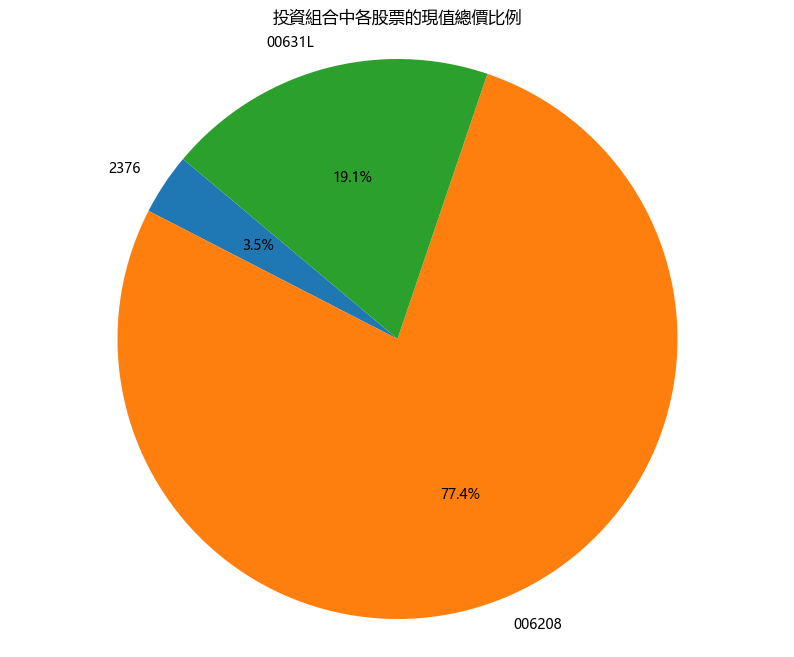

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# 讀取交易數據，設置編碼為 utf-8-sig 以避免中文亂碼
df = pd.read_csv('tw_train.csv', encoding='utf-8-sig')

# 創建空字典來存放交易數據
stock_counts = {}


import yfinance as yf

def get_taiwan_stock_name(ticker_symbol):
    # 自動補上 .TW
    if not ticker_symbol.endswith('.TW'):
        ticker_symbol += '.TW'
    
    # 獲取股票數據
    ticker = yf.Ticker(ticker_symbol)
    
    # 獲取公司名稱
    company_name = ticker.info.get('longName', '公司名稱未找到')
    
    return f"[{ticker_symbol}.{company_name}"

# 測試單一股票代碼
print(get_taiwan_stock_name('2330'))  # 台積電
print(get_taiwan_stock_name('2317'))  # 鴻海


# 遍歷每一列資料，計算每個股票的庫存股和總成本
for index, row in df.iterrows():
    stock_code = row['股票代號']
    stock_name = stock_code#get_taiwan_stock_name(stock_code)# row.get('股票名稱', '未知')
    count = row['股數']
    cost = float(row['進帳/出帳'])

    if pd.isna(stock_code) or pd.isna(count):
        continue

    if stock_code not in stock_counts:
        stock_counts[stock_code] = {'名稱': stock_name, '庫存股': 0, '總成本': 0}
    stock_counts[stock_code]['庫存股'] += count
    stock_counts[stock_code]['總成本'] += cost

# 使用 yfinance 獲取即時股價資料
data = []
for stock_code, data_dict in stock_counts.items():
    name = data_dict['名稱']
    count = data_dict['庫存股']
    cost = -data_dict['總成本']

    try:
        ticker = yf.Ticker(f"{stock_code}.TW")
        val = ticker.history(period='1d')['Close'].iloc[-1]
    except Exception as e:
        print(f"Error fetching data for {stock_code}: {e}")
        val = 0

    val_total = val * count
    gain = val_total - cost
    gain_per = (gain / cost) * 100 if cost != 0 else 0

    data.append([stock_code, name, count, val, val_total, cost, gain, gain_per])

# 轉換為 DataFrame
headers = ['股票代碼', '股票名稱', '庫存股', '股價', '現值總價', '總成本', '未實現損益', '未實現損益(%)']
portfolio_df = pd.DataFrame(data, columns=headers)

# 中文亂碼問題
def plt_chinese():
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # 修改中文字體
    plt.rcParams['axes.unicode_minus'] = False # 顯示負號

plt_chinese

# 過濾掉現值總價為 0 的股票
filtered_df = portfolio_df[portfolio_df['現值總價'] > 0]

# 自定義函數隱藏 0%
def autopct_format(pct):
    return f'{pct:.1f}%' if pct > 0 else ''

# 繪製圓餅圖
plt.figure(figsize=(10, 8))
plt.pie(filtered_df['現值總價'], 
        labels=filtered_df['股票名稱'], 
        autopct=autopct_format, 
        startangle=140)
plt.title('投資組合中各股票的現值總價比例')
plt.axis('equal')
plt.show()

Gadugi
SimSun
Yellowtail
Sylfaen
Georgia
Corbel
Georgia
Calibri
Cambria
Verdana
Sitka Small
Corbel
DFKai-SB
Cookie
Sitka Small
Montserrat Subrayada
Kalam
Courier New
Constantia
Segoe UI
Microsoft New Tai Lue
Lucida Sans Unicode
Consolas
Corbel
Kalam
Microsoft YaHei
Leelawadee UI
Ink Free
MS Gothic
Microsoft Yi Baiti
Corbel
Inter
Lucida Console
Arial
Microsoft PhagsPa
Orbitron
Segoe UI
Symbol
Times New Roman
Segoe UI
Comic Sans MS
Calibri
Trebuchet MS
Segoe UI
Inter
Arial
Segoe Script
Microsoft Tai Le
Microsoft JhengHei
Bowlby One SC
Quicksand
Times New Roman
Segoe UI
Russo One
Candara
HoloLens MDL2 Assets
Microsoft JhengHei
Cambria
Cabin Sketch
Candara
Verdana
Webdings
Cambria
Segoe UI Emoji
Verdana
Constantia
Shrikhand
MV Boli
Cascadia Code
Microsoft YaHei
Consolas
Trebuchet MS
Malgun Gothic
Calibri
Quicksand
Myanmar Text
Palatino Linotype
Impact
Fugaz One
Consolas
Segoe UI
Microsoft YaHei
Nirmala UI
Candara
Gabriola
Yu Gothic
Segoe UI
SimSun-ExtB
Times New Roman
Teko SemiBold
Playbal

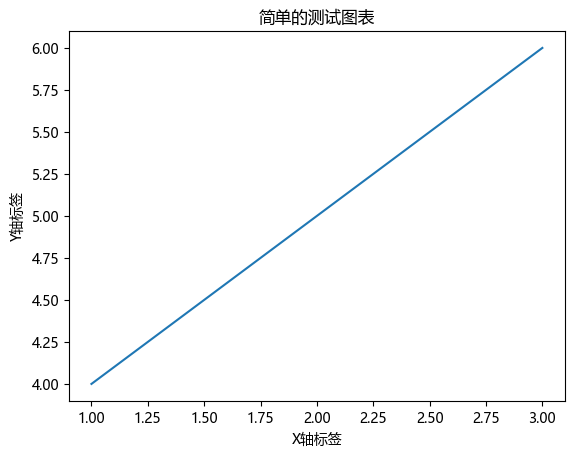

In [48]:
import matplotlib.font_manager as fm

fonts = fm.findSystemFonts()
for font in fonts:
    print(fm.FontProperties(fname=font).get_name())

    import matplotlib.pyplot as plt
from matplotlib import rcParams

# 设置中文字体，适用于大部分系统
rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 黑体
rcParams['axes.unicode_minus'] = False    # 正确显示负号

# 简单的折线图
plt.plot([1, 2, 3], [4, 5, 6])
plt.title('简单的测试图表')  # 标题包含中文
plt.xlabel('X轴标签')        # X轴标签
plt.ylabel('Y轴标签')        # Y轴标签

plt.show()